# AMR-KG

This notebook is used to generate and populate the AMR-KG with the data.

In [1]:
import string
import pandas as pd
from tqdm import tqdm

from neomodel import (config, StructuredNode, StringProperty, RelationshipTo, StructuredRel, FloatProperty, db)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [2]:
df = pd.read_csv('../data/processed/combined.tsv', sep='\t')
df.head(2)

,cmp_id,smiles,inchikey,bact,strain,val,val_type,source
0,pubchem.compound:2850780,COCC(C)NCc1ccc(C)cc1C,AAAFNFZYVYYALD-UHFFFAOYSA-N,Streptococcus pneumoniae serotype 2 (strain D3...,gram-positive,3.71,IC50,bindingdb
1,pubchem.compound:2850780,COCC(C)NCc1ccc(C)cc1C,AAAFNFZYVYYALD-UHFFFAOYSA-N,Streptococcus pneumoniae serotype 2 (strain D3...,gram-positive,2.00,IC50,bindingdb


# Generate graph
The graph can be generated and visualized using Neo4J desktop. Make sure to generate an admin user with the following configurations in the system setting of the database.
Username - user
Password - administrator

In [3]:
from neo4j import GraphDatabase
my_driver = GraphDatabase().driver('bolt://localhost:7687', auth=('user', 'administrator'))
config.DRIVER = my_driver

In [4]:
# Delete all nodes and relationships
db.cypher_query("MATCH ()-[r]-() DELETE r")  # delete all relationships
db.cypher_query("MATCH (n) DETACH DELETE n") # delete all nodes

([], [])

In [5]:
# Relation with properties
class Activity(StructuredRel):
    act_type = StringProperty()
    value = FloatProperty()
    db_source = StringProperty()

# Defining the nodes
class BacteriaStrain(StructuredNode):
    name = StringProperty(required=True, unique_index=True, unique=True)

class Bacteria(StructuredNode):
    name = StringProperty(required=True, unique_index=True, unique=True)

    # outgoing relations
    strain = RelationshipTo(BacteriaStrain, 'IS_A')

class Chemical(StructuredNode):
    name = StringProperty(required=True, unique_index=True, unique=True)
    smiles = StringProperty(index=True)
    inchikey = StringProperty(index=True)

    # outgoing relations
    activity = RelationshipTo(Bacteria, 'SHOWS_ACTIVITY_ON', model=Activity)

In [6]:
# Compound nodes
compound_nodes = df[['cmp_id', 'smiles', 'inchikey']].drop_duplicates()
for idx, smiles, inchikey in tqdm(compound_nodes.values):
    c = Chemical(name=idx, smiles=smiles, inchikey=inchikey).save()

100%|██████████| 64320/64320 [09:19<00:00, 114.95it/s]


In [7]:
# Bacteria nodes
bact_nodes = df['bact'].unique().tolist()
for bact_name in tqdm(bact_nodes):
    b = Bacteria(name=bact_name).save()

100%|██████████| 357/357 [00:03<00:00, 109.43it/s]


In [8]:
# Bacteria strain nodes
for bact_strain_name in tqdm(df['strain'].unique()):
    b = BacteriaStrain(name=bact_strain_name).save()

100%|██████████| 3/3 [00:00<00:00, 51.27it/s]


In [9]:
# Connecting the nodes based on schema

for cmp_id, _, _, bact, strain, value, act_type, db_source in tqdm(df.values):
    c = Chemical.nodes.first(name=cmp_id)
    b = Bacteria.nodes.first(name=bact)
    s = BacteriaStrain.nodes.first(name=strain)
    
    c.activity.connect(b, {'act_type': act_type, 'value': value, 'db_source': db_source})
    
    b.strain.connect(s)

  0%|          | 0/122730 [00:00<?, ?it/s]

100%|██████████| 122730/122730 [38:38<00:00, 52.94it/s] 


# Statistics on the graph

In [10]:
db.cypher_query("MATCH (n) RETURN labels(n) AS NodeType, count(n) AS NumberOfNodes")

([[['Chemical'], 64320], [['Bacteria'], 357], [['BacteriaStrain'], 3]],
 ['NodeType', 'NumberOfNodes'])

In [11]:
db.cypher_query("Match ()-[p]-() with type(p) as RelationshipName, count(p) as RelationshipNumber return RelationshipName, RelationshipNumber;")

([['SHOWS_ACTIVITY_ON', 233084], ['IS_A', 714]],
 ['RelationshipName', 'RelationshipNumber'])

In [12]:
data_nodes = {
    'Node Types': [
        'Chemical',
        'Bacteria',
        'BacteriaStrain',
    ],
    'Count':[
        64320,
        64320, 
        3
    ]
}

node_df = pd.DataFrame(data=data_nodes)
node_df

,Node Types,Count
0,Chemical,64320
1,Bacteria,64320
2,BacteriaStrain,3


In [13]:
data_edges = {
    'Edge Types':[
        'chemmical-bacteria',
        'bacteria-strain'
    ],
    'Count':[
        233084,
        714
    ]
}

edges_df = pd.DataFrame(data=data_edges)
edges_df

,Edge Types,Count
0,chemmical-bacteria,233084
1,bacteria-strain,714


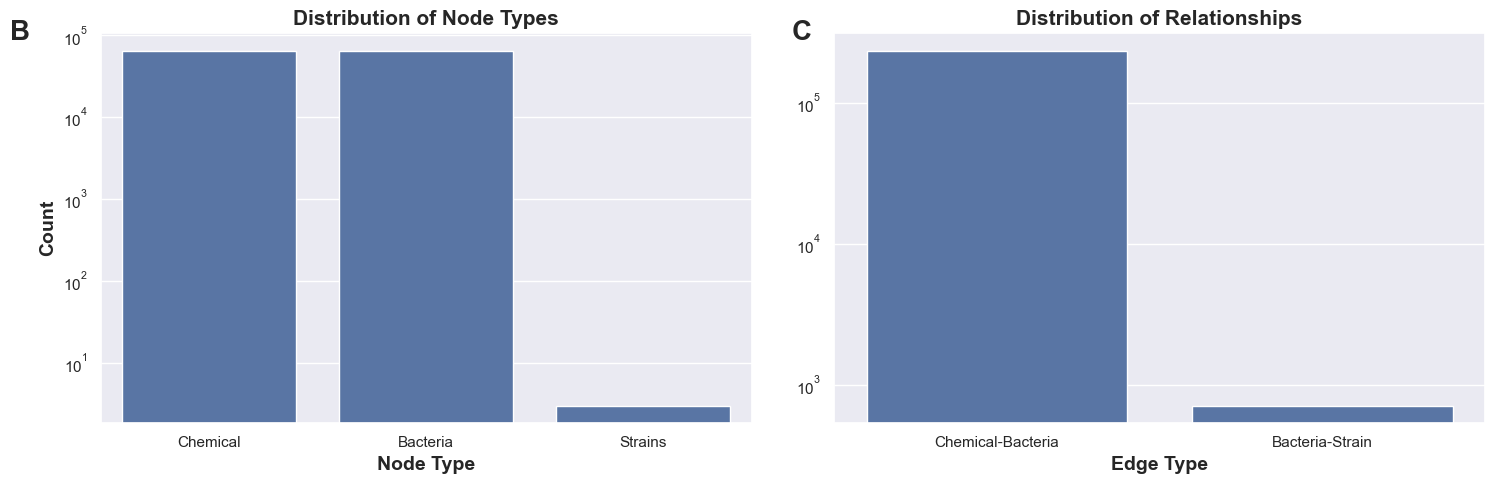

In [14]:
sns.set(rc={'figure.figsize':(15,5)})
f, axis = plt.subplots(1, 2, figsize=(15,5))

# grid lines
sns.set_style("darkgrid")

bx = sns.barplot(x="Node Types", y="Count", data=node_df, ax=axis[0]) 
bx = sns.barplot(x="Edge Types", y="Count", data=edges_df, ax=axis[1]) 

# title
axis[0].set_title(
    'Distribution of Node Types', 
    fontsize=15, 
    fontweight="bold"
)
axis[1].set_title(
    'Distribution of Relationships', 
    fontsize=15, 
    fontweight="bold"
)

# axis labels
axis[0].set_xlabel("Node Type", fontsize=14, fontweight="bold")
axis[0].set_ylabel("Count", fontsize=14, fontweight="bold")
axis[1].set_xlabel("Edge Type", fontsize=14, fontweight="bold")
axis[1].set_ylabel("")   
    
# axis ticks
axis[0].set_xticklabels(labels=['Chemical', 'Bacteria', 'Strains'])
axis[1].set_xticklabels(labels=['Chemical-Bacteria','Bacteria-Strain'])

plt.tight_layout()
axis[0].set_yscale("log") #the log transformation
axis[1].set_yscale("log") #the log transformation

axis[0].text(-1.25, 1, string.ascii_uppercase[1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

axis[1].text(-0.05, 1, string.ascii_uppercase[2],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.savefig(
    '../figures/figure_2b.png',
    dpi=500,
    bbox_inches='tight', 
)
plt.show()